# Inference: Slice Sampling with Overrelaxation
This example shows you how to perform Bayesian inference on a Gaussian distribution and a time-series problem, using
Slice Sampling with Stepout and Overrelaxation.

Overrelaxed steps increase sampling efficiency in highly correlated
    unimodal distributions by suppressing the random walk behaviour of
    single-variable slice sampling: each variable is still updated in turn,
    but rather than drawing a new value for a variable from its conditional
    distribution independently of the current value, the new value is instead
    chosen to be on the opposite side of the mode from the current value. The
    interval ``I`` is still calculated via Stepout, and the edges ``l,r`` are
    used to estimate the slice endpoints via bisection. To obtain a full
    sampling scheme, overrelaxed updates are alternated with normal Stepout
    updates.

First, we create a simple normal distribution.

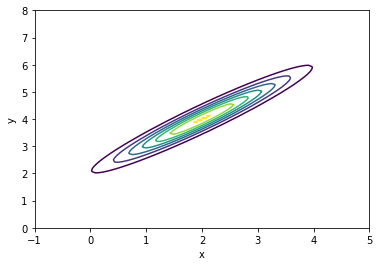

In [5]:
import os
os.chdir("../")
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
log_pdf = pints.toy.GaussianLogPDF([2, 4], [[1, 0.96], [0.96, 1]])

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-1, 5, num_points)
y = np.linspace(-0, 8, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Set MCMCController and Overrelaxation Parameter

The probability of pursuing an overrelaxed step, ``_prob_overrelaxed`` (0 as default), and the number of bisection iterations, ``a``, are hyperparameters. In [1], Neal suggests to set almost every update to being overrelaxed and to set a high number of interval expansion steps ``m``.

[1] Neal, R.M., 2003. Slice sampling. The annals of statistics, 31(3),
    pp.705-767.

In [7]:
# Choose starting point for 3 mcmc chains
xs = [
    [2, 4],
    [3, 3],
    [5, 4],
]

# Create mcmc routine
mcmc = pints.MCMCController(log_pdf, 3, xs, method=pints.SliceStepoutMCMC)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(1000)

for sampler in mcmc.samplers():
    sampler.set_w([0.1, 0.1])
    sampler.set_m(100)
    sampler.set_prob_overrelaxed(0.95)
    sampler.set_a(10)
    
# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Slice Sampling - Stepout
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     325     0:00.0
2     540     0:00.0
3     721     0:00.0
1000  183531   0:06.0
2000  367569   0:11.9
3000  551599   0:17.8
4000  736172   0:23.7
5000  921389   0:29.7
6000  1106101   0:35.6
7000  1289851   0:41.4
8000  1472767   0:47.3
9000  1655821   0:53.2
10000 1837900   0:59.0
Halting: Maximum number of iterations (10000) reached.
Done!


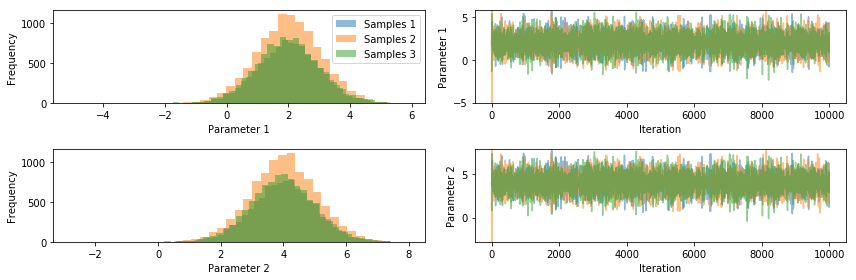

In [8]:
# Show traces and histograms
import pints.plot
pints.plot.trace(full_chains)
plt.show()

R-hat:
[1.0002471973523204, 1.0002325399658236]
0.0010408999190298918
0.0036806059203877695
0.0023659895213810067


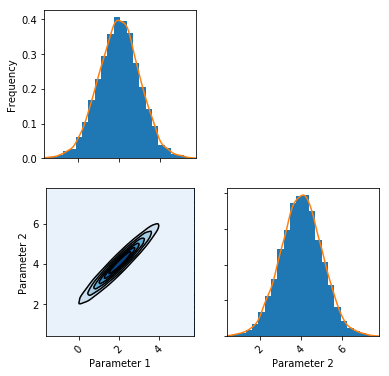

In [9]:
# Discard warm up
chains = full_chains[:, 200:]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Check Kullback-Leibler divergence of chains
print(log_pdf.kl_divergence(chains[0]))
print(log_pdf.kl_divergence(chains[1]))
print(log_pdf.kl_divergence(chains[2]))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)
plt.show()

# Slice Sampling with Doubling on a time-series problem
We now try the same method on a time-series problem

In [17]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise * 0.1],
    [0.02, 600, noise * 100],
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
num_chains = 3
xs = [
    real_parameters * 1.1,
    real_parameters * 0.9,
    real_parameters * 1.15,
]

# Create mcmc routine
mcmc = pints.MCMCController(
    log_posterior, num_chains, xs, method=pints.SliceStepoutMCMC)

for sampler in mcmc.samplers():
    sampler.set_w(1)
    sampler.set_m(100)
    sampler.set_prob_overrelaxed(0.90)
    sampler.set_a(10)
    
# Add stopping criterion
mcmc.set_max_iterations(10000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(1000)

# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Slice Sampling - Stepout
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     523     0:00.1
2     1064    0:00.1
3     1520    0:00.1
1000  179047   0:14.0
2000  356893   0:27.2
3000  535794   0:39.7
4000  713967   0:52.8
5000  891976   1:05.3
6000  1069915   1:17.7
7000  1248523   1:30.2
8000  1425999   1:42.7
9000  1602985   1:55.1
10000 1779934   2:07.5
Halting: Maximum number of iterations (10000) reached.
Done!


R-hat:
[1.0005203254978967, 1.0000218624723907, 0.9999581828935821]


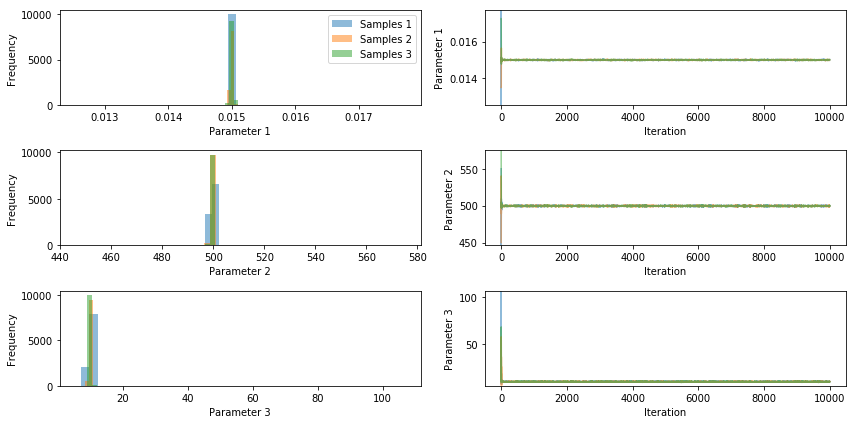

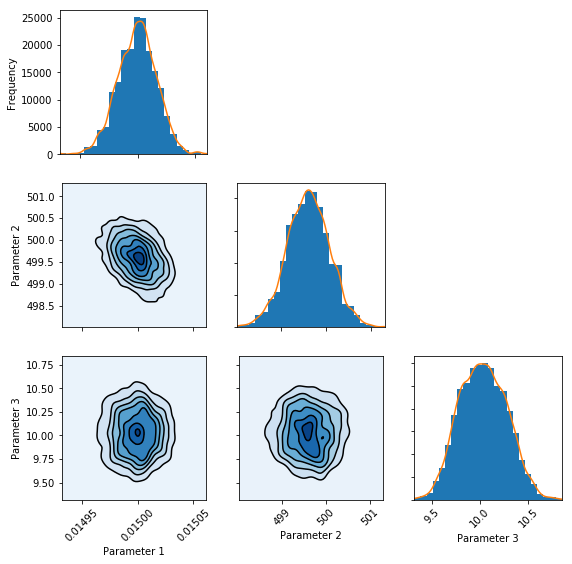

In [18]:
# Show traces and histograms
pints.plot.trace(full_chains)

# Discard warm up
full_chains = full_chains[:, 200:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(full_chains))

# Look at distribution in chain 0
pints.plot.pairwise(full_chains[0], kde=True)

# Show graphs
plt.show()